In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

from scipy.optimize import minimize, OptimizeResult
from collections import defaultdict
from itertools import zip_longest
from functools import partial

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from copy import deepcopy

## <span style="color:blue">Implementation (Students do)</span>
<hr/>

### Methods
You will implement five optimization algorithms (descriptions available [here](https://web.archive.org/web/20230121055130/https://ruder.io/optimizing-gradient-descent/index.html)).
- Gradient descent (`gd`)
- MirrorDescent (`mirrD`)
- Accelerated gradient method (`acc`)
- Adaptive gradient method (`adagrad`)
- Adaptive moment estimation (`adam`)

The last is a very common optimizer used in practical applications -- possibly the most common in the world.

In addition, you will also implement a method for mirrorstep for the entropy regularizer and the ell_2 regularizer `mirrorstep_entropy/ell_2`. The latter of which you will use for the mirror descent algorithm and may also use for the accelerated method implementation.
Make note of the function headers: `def gd(func, x, lr, num_iters, grad):`.
- `func`: [type: function] The loss function. Takes in a point of type np.ndarray (n,) for some n and returns a float representing the value of the function at that point.
- `x`: [type: np.ndarray (n,)] The starting point of the optimization.
- `lr`: [type: real] Learning rate.
- `num_iters`: [type: int] The number of iterations of the optimization method to run.
- `grad`: [type: function] The gradient of the loss function. Takes in a point of type np.ndarray (n,) and returns an np.ndarray (n,) representing the gradient of the function at that point.

Each function will need to return a `np.ndarray` containing all the iterates over the course of the optimization.


In [2]:
#takes as input an x which is on the n-dimensional unit simplex, lr is a FIXED SCALAR Learning Rate (not a schedule function like the rest of the problem) and grad is a vector which returns gradient of a given function at point x. Return the next iterate of the mirror step.
def mirrorstep_entropy(x, lr, grad):
    return np.multiply(x, np.exp(-grad * lr))
#same as above except x lies in R^n inside of the unit simplex.
def mirrorstep_ell_2(x, lr, grad):
    return x - lr * grad

In [3]:
def gd(func, x, lr, num_iters, grad): # lr = 0.02
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        update = - lr * grad(x)
        x += update
        iterates.append(deepcopy(x))
    return np.array(iterates)

In [4]:
def mirrorD(func, x, lr, num_iters, grad): # lr = 0.2
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        gk = grad(x)
        update = mirrorstep_ell_2(x, lr, gk)
        x = update
        iterates.append(deepcopy(x))
    return np.array(iterates)


In [5]:
#we will not use a learning rate but rather use a parameter L which denotes the Lipshitz constant of the function to be optimized. Use the stepsize/learning rates you got from the PDF part of the problem. Return the y sequence of iterates
def acc(func, x, L, num_iters, grad): #lr = 1.9
    iterates = []
    y = x
    z = x
    tau = 0
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        tau = 2 / (itr + 2)
        x = tau * z + (1 - tau) * y
        y = x - (1/L) * grad(x)
        eta = 1 / (tau * L)
        z = mirrorstep_ell_2(z, eta, grad(x))
        iterates.append(deepcopy(y))
    return np.array(iterates)

In [6]:
def adagrad(func, x, lr, num_iters, grad, eps=1e-5): # lr = 0.02 
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        gt = grad(x)
        #print(gt)
        G = gt * gt #np.diag(gt * gt) gt is scalar here #fix for logistic below
        #print(np.sqrt(G + eps))
        update = (lr * np.reciprocal(np.sqrt(G + eps))) * gt
        x = x - update
        
        iterates.append(deepcopy(x))
    
    return np.array(iterates)

In [7]:
def adam(func, x, lr, num_iters, grad, beta1=0.9, beta2=0.999, eps=1e-5): #lr = 0.02
    iterates = []
    mt = 0
    vt = 0
    beta1exp = beta1
    beta2exp = beta2
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        gt = grad(x)
        mt = beta1 * mt + (1 - beta1) * gt
        vt = beta2 * vt + (1 - beta2) * gt * gt
        mt_hat = mt / (1 - beta1exp)
        vt_hat = vt / (1 - beta2exp)
        beta1exp *= beta1
        beta2exp *= beta2
        update = - lr * np.multiply(np.reciprocal(np.sqrt(vt_hat) + eps), mt_hat)
        x += update
        iterates.append(deepcopy(x))
    return np.array(iterates)


## Testing your code
We are not providing much structure here, but now is a good time to make sure your optimization methods are working well. The cell below tests your gradient descent method on the function $f(x)=x^2$.

In [11]:
x_squared_fval = lambda x: x**2
x_squared_grad = lambda x: 2*x
iterates = acc(x_squared_fval, 2, 1.9, 100, x_squared_grad)
res=[(i,x,x_squared_fval(x)) for (i,x) in enumerate(iterates)]
#print([x[2] for x in res])

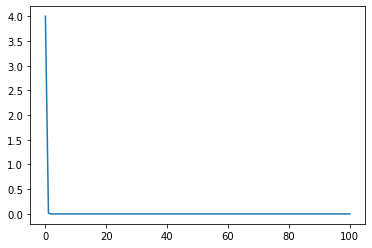

In [12]:
plt.plot([x[2] for x in res])

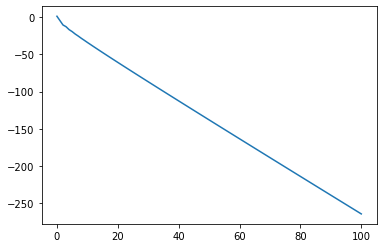

In [13]:
plt.plot([np.log(x[2]) for x in res])

In [15]:
res[1]

(1, -0.10526315789473673, 0.011080332409972275)

## <span style="color:red">Submission: Challenge</span>
<span style="color:red">In this part, you will implement the lambda functions for the functional value and the gradient function for logistic regression function given a data matrix X and output vector y. Finally you will run the above algorithms that you implemented for a classification dataset. </span>

In [16]:
np

<module 'numpy' from '/Users/rohan/opt/anaconda3/lib/python3.9/site-packages/numpy/__init__.py'>

In [55]:
np.log(10)

2.302585092994046

In [176]:
#1/n \sum_i y_i log(1/(1+e^(-x_i^t w)) + (1-y_i) log(1-1/(1+e^(-x_i^t w))
def logistic_regression_fval(X,y,w):
    s = 0
    num_ex = X.shape[0]
    for i in range(num_ex):
        expo = np.exp(-np.dot(X[i], w))
        L = y[i] * np.log(1/(1 + expo))
        R = (1 - y[i]) * np.log(1 - (1/ (1 + expo)))
        s += - (L + R)
        #print(i, s)
    s /= num_ex
    return s
    
    
    #eps = 1e-10
    #denom = np.exp(-np.matmul(X, w)) + 1
    #logparam1 = np.reciprocal(denom)
    #log1 = np.log(logparam1 + eps)
    #log2 = np.log(1-logparam1 + eps)
    #ret = y * log1 + (- y + 1) * log2
    
    #print(ret)
    #print("-----------------------------")
    #print("-----------------------------")
    #print("-----------------------------")
    #return ret / num_ex

def logistic_regression_grad(X,y,w):
    num_ex = X.shape[0]
    num_param = X.shape[1]
    s = np.array([0] * num_param)
    for i in range(num_ex):
        expo = np.exp(-np.dot(X[i], w))
        R = 1/(1 + expo) - y[i]
        s = s + X[i] * R
    #print(s.shape)
    return s / num_ex
        
    
    #num_param = X.shape[1]
    #E = np.exp(-np.matmul(X,w))
    #d = np.reciprocal(E + 1) - y
    #ret = np.matmul(X.T,d) / num_param
    #print(ret.shape)
    #return ret

In [177]:
# Standard GD

In [178]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = gd(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

In [179]:
X.shape, y.shape

((569, 30), (569,))

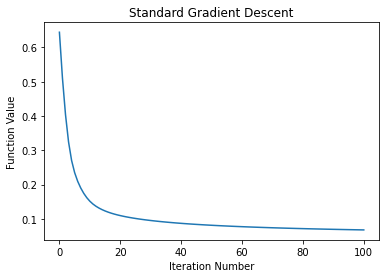

In [180]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.title("Standard Gradient Descent")
plt.show()

In [181]:
# Mirror Descent

In [182]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = mirrorD(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_98974/1840816933.py:8: RuntimeWarning: divide by zero encountered in log
  R = (1 - y[i]) * np.log(1 - (1/ (1 + expo)))


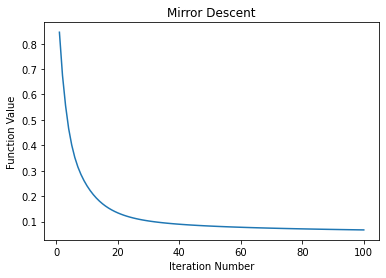

In [183]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.title("Mirror Descent")
plt.show()

In [184]:
# Accelerated GD (Gradient + Mirror Descent)

In [185]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = acc(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

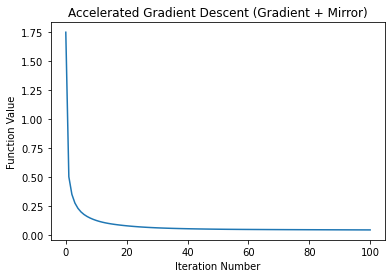

In [186]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.title("Accelerated Gradient Descent (Gradient + Mirror)")
plt.show()

In [187]:
# Adagrad

In [188]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = adagrad(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.01,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_98974/3452477917.py:9: RuntimeWarning: invalid value encountered in reciprocal
  update = (lr * np.reciprocal(np.sqrt(G + eps))) * gt


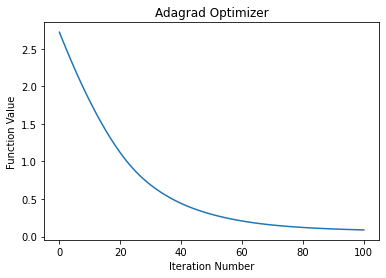

In [189]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.title("Adagrad Optimizer")
plt.show()

In [190]:
# Adam

In [191]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = adam(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.01,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_98974/3394900157.py:17: RuntimeWarning: invalid value encountered in reciprocal
  update = - lr * np.multiply(np.reciprocal(np.sqrt(vt_hat) + eps), mt_hat)


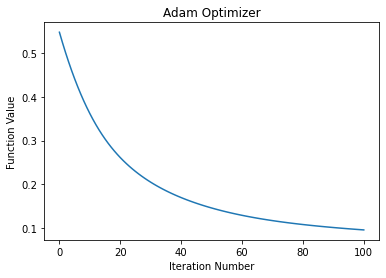

In [192]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.title("Adam Optimizer")
plt.show()

Run the above code for all the different algorithms and report the convergence behavior of all the algorithms. Add the plots of the function value decrease over all iterates to a PDF file (or add different cells for the run of each algorithm and the plotting and you can just use the PDF of the jupyter notebook. )

## Analysis 

Here, we implemented classification algorithms for breast cancer detection and tested the following optimization algorithms off of a logistic loss function: Gradient Descent, Mirror Descent, Accelerated Gradient Descent, Adagrad, and Adam. Each of these algorithms eventually converged to an optimal selection of weights that minimized loss over the training data. However, their behavior was quite different. Gradient and Mirror Descent both had a similar convergence rate that was quite large at first and then leveled off. Accelerated Gradient Descent, on the other hand, converged much more quickly as expected. Coupling both gradient and mirror descent, it had much more steep initial update steps and according to the graph, reaching the same loss values much earlier into the iteration. Next, Adagrad had a much more stable descent compared to gradient and mirror descent, with more gradual and less steep update steps. This is as expected since Adagrad normalizes the learning rate by the magnitude of the gradient. Lastly, the adam optimizer, which is the most popular one used for modern applications, performed very similarly to Adagrad but with slightly less steep update steps and overall had the most evenly distributed update steps. 